# U-net Paper Replication

- Original Paper: https://arxiv.org/abs/1505.04597

In [1]:
!nvidia-smi

Fri May 24 10:30:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   65C    P0             17W /   80W |       6MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.2+cu121
torchvision version: 0.17.2+cu121


In [3]:
import os
import sys
from pathlib import Path

sys.path.insert(0, str(Path(os.getcwd()).parent))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


In [5]:
BATCH_SIZE = 8
IMAGE_SIZE = (256, 512)
NUM_WORKERS = 2

SEED = 42

## 01. Data

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from src.data.dataset import DATASET_NAME
from src.data.dataloader import get_dataloaders


transform_train = A.Compose(
    [
        A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        A.HorizontalFlip(),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        A.ToGray(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

transform_test = A.Compose(
    [
        A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

train_dataloader, test_dataloader, num_classes = get_dataloaders(
    dataset=DATASET_NAME.CITYSCAPES,
    root=Path("/home/geri/work/dataset/cityscapes"),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    transform_train=transform_train,
    transform_test=transform_test,
)

/home/geri/.venv/computer_vision/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


(-0.5, 511.5, 255.5, -0.5)

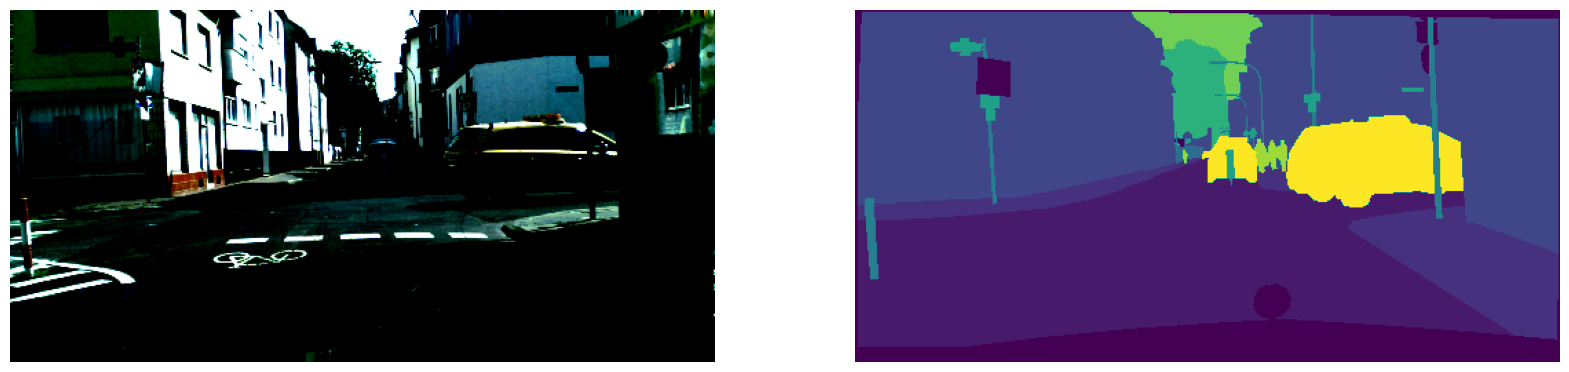

In [7]:
import matplotlib.pyplot as plt

img, target = next(iter(test_dataloader))

fig = plt.figure(figsize=(20, 30))

fig.add_subplot(1, 2, 1)
plt.imshow(img[0].permute(1, 2, 0))
plt.axis(False)

fig.add_subplot(1, 2, 2)
plt.imshow(target[0])
plt.axis(False)

In [8]:
import numpy as np

print(f"Image Size: {img[0].shape}\tTarget Size: {target[0].shape}")
print(f"Labels in target image: {np.unique(target[0])}")

Image Size: torch.Size([3, 256, 512])	Target Size: torch.Size([256, 512])
Labels in target image: [ 0  1  2  3  5  6  8  9 11 12 14]


## 02. Model

In [9]:
from src.models.unet.unet import UNet
from torchinfo import summary

model = UNet(out_channels=num_classes).to(device)

summary(
    model,
    input_size=(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                                   [1, 3, 256, 512]     [1, 20, 256, 512]    --                   True
├─Encoder (encoder)                           [1, 3, 256, 512]     [1, 512, 16, 32]     --                   True
│    └─ModuleList (layers)                    --                   --                   (recursive)          True
│    │    └─DoubleConv (0)                    [1, 3, 256, 512]     [1, 64, 256, 512]    38,848               True
│    └─MaxPool2d (pool)                       [1, 64, 256, 512]    [1, 64, 128, 256]    --                   --
│    └─ModuleList (layers)                    --                   --                   (recursive)          True
│    │    └─DoubleConv (1)                    [1, 64, 128, 256]    [1, 128, 128, 256]   221,696              True
│    └─MaxPool2d (pool)                       [1, 128, 128, 256]   [1, 128, 64, 128] 

## 03. Train

In [10]:
import src.utils.loggers as loggers

root = Path(os.getcwd()).parent
writer = loggers.create_tensorboard_writer(
    path=root / "runs",
    experiment_name="Cityscapes_Segmentation",
    model_name="U-Net",
    extra="batch-8_lr-10e-4_weight-decay-10e-7_dice-loss",
)

model_saver = loggers.ModelSaver(path=root / "checkpoints", model_name="U-Net")

In [11]:
from torch import nn

from src.models.train import train
from src.utils.losses import DiceLoss

EPOCHS = 100

loss_fn = DiceLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=10e-3, weight_decay=10e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=EPOCHS, eta_min=10e-6)

train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    device=device,
    writer=writer,
    model_saver=model_saver,
    use_amp=True,
)

  0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

Train:   0%|          | 0/372 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]